<a href="https://colab.research.google.com/github/AnLiMan/Recognition-of-defects-on-the-metal-surface/blob/main/Machine_Learning_v_0_8_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Инструкция по работе
- Если обученная нейросеть с сохранённой моделью отсутствует, то прогоняем все ячейки последовательно. Для сохранения модели изменяем значение "number_of_interations" в 1-й ячейке на то, которое хотим. Сохраняется всё по адресу, который указан в ячейке "Обучение нейросети".
- В случае если имеется уже обученная и сохранённая модель запускаем все ячейки, кроме "Обучение нейросети", на ошибки в некоторых блоках не обращаем внимания. Порядковый номер модели находится в параметр "number_of_interations" в 1-й ячейке.
- Глава "Визуализация предсказаний" показывает 16 случайно выбранных изображений из тестовой выборки, проверить каждое изображение отдельно можно в ячейке "тест программы"
-Для первых 6 итераций ипользовался датасет NEU2, для последующих NEU3. Для выбора того или иного датасета в ячейке "Определение данных для тестирования и создание архитектуры нейросети", в строке 10 исправить конечный архив на NEU2 или NEU3, а также при определении архитектуры сети вставить строчку: "tf.keras.layers.Dense(7, activation='softmax')"

by AnLi

#Результаты тестов
Для NEU2. Датасет включает в себя по 300 изображений 6 дефектов: царапины, вдавленные окалины, пятна, волосные трещины, рябизна; посторонние включения. Соотношение тренировочной выборки к тестовой = 91,67% к 8,33%

- 1 Итерация.
loss: 0.2532 - accuracy: 0.9254 - val_loss: 0.4438 - val_accuracy: 0.8974
- 2 Итерация.
loss: 0.3809 - accuracy: 0.8973 - val_loss: 0.9834 - val_accuracy: 0.8333
- 3 Итерация.
loss: 0.6127 - accuracy: 0.8133 - val_loss: 0.5532 - val_accuracy: 0.8077
- 4 Итерация.
loss: 0.3549 - accuracy: 0.9186 - val_loss: 0.3244 - val_accuracy: 0.8846
- 5 Итерация.
loss: 0.2655 - accuracy: 0.9182 - val_loss: 0.5352 - val_accuracy: 0.8462
- 6 Итерация.
loss: 0.2637 - accuracy: 0.9333 - val_loss: 0.4073 - val_accuracy: 0.9359

Для NEU3. Датасет включает в себя по 300 изображений 6 дефектов: царапины, вдавленные окалины, пятна, волосные трещины, рябизна; посторонние включения, а также 300 изображений чистой поверхности металла. Соотношение тренировочной выборки к тестовой = 91,67% к 8,33%

- 7 Итерация.
loss: 0.3305 - accuracy: 0.9009 - val_loss: 1.2706 - val_accuracy: 0.8132
- 8 Итерация.
loss: 0.2722 - accuracy: 0.9158 - val_loss: 0.8443 - val_accuracy: 0.7912
- 9 Итерация.
loss: 0.2344 - accuracy: 0.9212 - val_loss: 0.7103 - val_accuracy: 0.8901
- 10 Итерация. 
loss: 0.1998 - accuracy: 0.9548 - val_loss: 0.8002 - val_accuracy: 0.9231

#Подключение библиотек, гугл диска и определение текущего номера итерации

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 10
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  10


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from __future__ import absolute_import, division, print_function, unicode_literals
import time

!pip install -q pyyaml h5py  # Требуется для сохранения модели в формате HDF5
zip_file = '/content/drive/My Drive/Files for colab/NEU3.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir)

<built-in function listdir>


#Определение данных для тестирования и создание архитектуры нейросети

In [ ]:
#перед этим создайте папку с данными train и в папке train создайте еще шесть папок для шести дефектов
import shutil
import numpy as np

try:
    source1 = "NEU/train"
    os.mkdir("NEU/test")
    dest11 = "NEU/test"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num = int(len(os.listdir(source1 + '/'+ f))*0.08)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")


Все уже есть в каталоге. Вам не нужно запускать эту ячейку


## Разделение тестовой и тренировочных выборок

In [ ]:
import shutil
import numpy as np

try:
    source1 = "NEU/test"
    os.mkdir("NEU/valid")
    dest11 = "NEU/valid"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num=int(len(os.listdir(source1 + '/'+ f))*0.5)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")


Все уже есть в каталоге. Вам не нужно запускать эту ячейку


##Определение архитектуры нейросети

Метод batch сообщает методу тренировки model.fit использовать блоки по 10 изображений и метки при обновлении внутренних переменных модели.

In [ ]:
# Все изображения будут смасштабированы к 1./255
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Обучающие изображения партиями по 10 с использованием генератора train_datagen
train_generator = train_datagen.flow_from_directory('NEU/train', target_size = (200, 200), batch_size = 10, class_mode = 'categorical')

# Тестовая выборка по 10 пакетов с использованием генератора train_datagen
validation_generator = test_datagen.flow_from_directory('NEU/valid', target_size = (200, 200), batch_size = 10, class_mode = 'categorical')

Found 1925 images belonging to 7 classes.
Found 91 images belonging to 7 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.92 ):
            print("\nТочность расчёта более 93%, расчёт был остановлен!")
            self.model.stop_training = True 

Процесс преобразования 2D-изображения в вектор называется сглаживанием (flattening) и реализуется посредством сглаживающего слоя — flatten-слоя.

ReLU — функция активации нейрона. Функция ReLU возвращает 0, если в качестве входного значения было отрицательное значение или ноль, во всех остальных случаях функция вернёт исходное входное значение.

Softmax — функция, которая вычисляет вероятности для каждого возможного выходного класса;


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print('Модель свёрточной сети создана')
model.summary()

Модель свёрточной сети создана
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 199, 199, 8)       104       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 98, 98, 32)        1056      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)    

# Обучение нейросети

In [ ]:
callbacks = myCallback()
checkpoint_path = "/content/drive/My Drive/Files for colab/Checkpoint_for_machine_learning_" + str(number_of_interations) + ".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)
history = model.fit(train_generator, batch_size = 16, epochs = 15, validation_data = validation_generator, callbacks=[cp_callback], verbose = 1, shuffle = True)
# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/Machine_learning_model_" + str(number_of_interations) + ".h5")

Epoch 1/15
193/193 [==============================] - 72s 375ms/step - loss: 0.1822 - accuracy: 0.9532 - val_loss: 1.7580 - val_accuracy: 0.7143

Epoch 00001: saving model to /content/drive/My Drive/Files for colab/Checkpoint_for_machine_learning_10.ckpt
Epoch 2/15
193/193 [==============================] - 74s 385ms/step - loss: 0.2495 - accuracy: 0.9429 - val_loss: 0.7840 - val_accuracy: 0.9121

Epoch 00002: saving model to /content/drive/My Drive/Files for colab/Checkpoint_for_machine_learning_10.ckpt
Epoch 3/15
193/193 [==============================] - 77s 399ms/step - loss: 0.2464 - accuracy: 0.9449 - val_loss: 0.3787 - val_accuracy: 0.9451

Epoch 00003: saving model to /content/drive/My Drive/Files for colab/Checkpoint_for_machine_learning_10.ckpt
Epoch 4/15
193/193 [==============================] - 76s 394ms/step - loss: 0.2110 - accuracy: 0.9512 - val_loss: 1.2826 - val_accuracy: 0.8022

Epoch 00004: saving model to /content/drive/My Drive/Files for colab/Checkpoint_for_machi

Графики результатов обучения

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  

# обобщение истории для точности   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # обобщение истории для потерь    
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

#Загрузка и работа с обученной моделью

In [ ]:
# Восстановим в точности ту же модель, включая веса и оптимизатор
Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/Machine_learning_model_" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 199, 199, 8)       104       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 98, 98, 32)        1056      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36864)            

In [ ]:
# Загрузим имена файлов и их соответствующие целевые метки в массив numpy
from sklearn.datasets import load_files
import numpy as np

test_dir = 'NEU/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
print('Количество классов: ', no_of_classes)

Количество классов:  7


In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
# У нас есть только имена файлов в наборе x. Загрузим изображения и преобразуем их в массив.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Преобразование в массив Numpy
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов): ', x_test.shape)

Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов):  (175, 200, 200, 3)


In [ ]:
x_test = x_test.astype('float32')/255

##Визуализация предсказаний

Время выполнения операции =  0.198652982711792  c


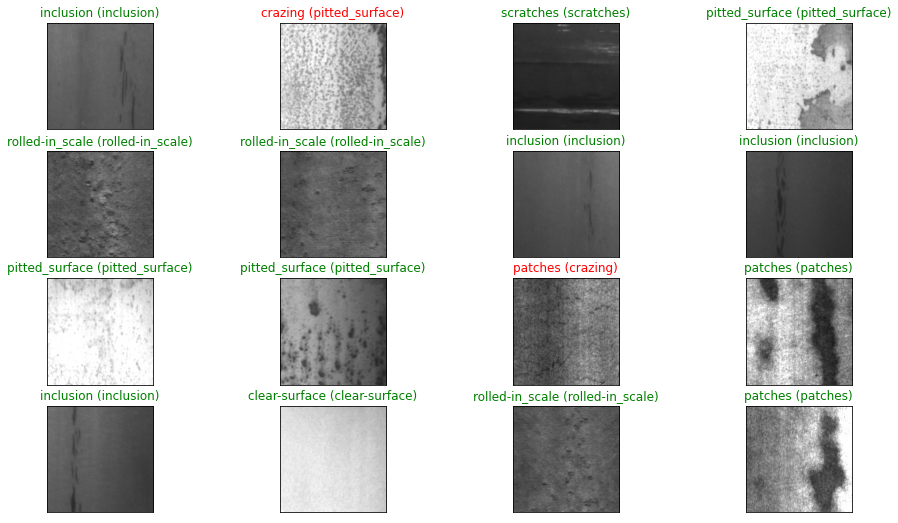

In [ ]:
import matplotlib.pyplot as plt

y_pred = Loading_model.predict(x_test)
start_time = time.time()
# построение случайной выборки тестовых изображений, их предсказанные метки и  истинного значения
fig = plt.figure(figsize = (16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 16, replace = False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color = ("green" if pred_idx == true_idx else "red"))

print("Время выполнения операции = ", (time.time() - start_time), ' c')

Тест программы

Введите номер изображения, для теста из тестовой выборки (от 0 до 83)
5
Время выполнения операции =  0.017658233642578125  c


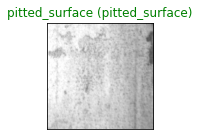

In [ ]:
import matplotlib.pyplot as plt

print('Введите номер изображения, для теста из тестовой выборки (от 0 до 83)')
idx = int(input())

start_time = time.time()
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
ax.imshow(np.squeeze(x_test[idx]))
pred_idx = np.argmax(y_pred[idx])
true_idx = np.argmax(y_test[idx])
ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))
print("Время выполнения операции = ", (time.time() - start_time), ' c')

##Прогон всей тестовой выборки

In [ ]:
import matplotlib.pyplot as plt

print('Прогон всех тестовых изображений по порядку')

for k in range(84):

  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot(4, 4, 2, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[k]))
  pred_idx = np.argmax(y_pred[k])
  true_idx = np.argmax(y_test[k])
  ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))


##Уберём визуализирующую состовляющую, чтобы вычислить время, требующееся для расчёта одного изображения

In [ ]:
print('Введите номер изображения, для теста из тестовой выборки (от 0 до 83)')
idx = int(input())

start_time = time.time()
pred_idx = np.argmax(y_pred[idx])
print('Номер дефекта: ', pred_idx)
print("Время выполнения операции = ", (time.time() - start_time), ' c')
time_for_operation = (time.time() - start_time)
print("Расшифровка: crazing = 1, inclusion = 2, patches = 3, plitted surface = 4, rolled in scale = 5, scratches = 6, clear surface = 7")

Введите номер изображения, для теста из тестовой выборки (от 0 до 83)
5
Номер дефекта:  4
Время выполнения операции =  0.0003800392150878906  c
Расшифровка: crazing = 1, inclusion = 2, patches = 3, plitted surface = 4, rolled in scale = 5, scratches = 6, clear surface = 7


#Работа с камерой

##Расчёты параметров для камеры, времени и т.д.

In [ ]:
import math

width = 1.9 #Ширина листопроката
cam_length = 4096 #Разрешение камеры по длине
cam_width = 3000 # Разрешение камеры по высоте
alpha = 72 #Угол обзора камеры

b = width * cam_length / cam_width  #Длина участка полосы проката в м
alpha_rad = alpha / 59.29577 # Из градусов в радианы

edge_of_the_pyramid = b * math.sqrt(2 - 2* math.cos(alpha_rad)) / (2 - 2* math.cos(alpha_rad)) #Вычисление ребра пирамиды (стороны треугольника MON)
cam_height = math.sqrt( edge_of_the_pyramid*edge_of_the_pyramid - (b / 4)) #Высота камеры над листом ОН
length_for_pixel = b/cam_length #Соотношение одного пикселя к длине полосы
width_for_pixel = b/cam_width #Соотношение одного пикселя к ширине полосы

print('При длине полосы, попавшей в объектив = ' + str(round(b, 3)) + ' м')
print('Высота камеры над листом = ', str(round(cam_height, 3)) + ' м')
print('Один пиксель соответствует длине листа в ' + str (round (length_for_pixel, 6)) + ' м')
print('Один пиксель соответствует ширине листа в ' + str (round (width_for_pixel, 6)) + ' м')

#Посчитаем количество фрагментов для 1 кадра для анализа
number_of_fragments_in_length = int(cam_length / 200) 
print('Фрагментов по длине = ', int(number_of_fragments_in_length))
number_of_fragments_in_width = int(cam_width / 200)
print('Фрагментов по ширине = ', number_of_fragments_in_width)
print('Всего фрагментов = ', number_of_fragments_in_length * number_of_fragments_in_width)
time_for_frame_operation = number_of_fragments_in_length * number_of_fragments_in_width * time_for_operation
print('Время на обработку одного кадра = ', time_for_frame_operation, 'c')

#Расчёт промужутка времени через который будет делаться 1 кадр
velocity = 1.25 #Скорость листопроката м/с
time_frame = b / velocity #Промежуток времени через который будет делаться снимок
print('Промежуток времени через который будет делаться снимок = ' + str(round (time_frame, 4)) + ' c')
print('Запас или недостаток (знак минус) по времени = ', (time_frame - time_for_frame_operation ), ' c')

При длине полосы, попавшей в объектив = 2.594 м
Высота камеры над листом =  2.126 м
Один пиксель соответствует длине листа в 0.000633 м
Один пиксель соответствует ширине листа в 0.000865 м
Фрагментов по длине =  20
Фрагментов по ширине =  15
Всего фрагментов =  300
Время на обработку одного кадра =  0.08890628814697266 c
Промежуток времени через который будет делаться снимок = 2.0753 c
Запас или недостаток (знак минус) по времени =  1.986400378519694  c


##Подключение камеры и создание снимков с определённой периодичностью (в google colab не запустится)

In [ ]:
import cv2

cap = cv2.VideoCapture(0)# Подключаемся (захватываем) нашу веб камеру. 0 — это индекс камеры, если их несколько то будет 0 или 1 и т.д.

while True:
    ret, img = cap.read() # Читаем с устройства кадр, метод возвращает флаг ret (True , False) и img — саму картинку ( массив numpy)
    cv2.imshow("camera", img) # Функция imshow отображает изображение в указанном окне
    if cv2.waitKey(10) == 27: # Клавиша Esc
        break
cap.release()
cv2.destroyAllWindows()

#Оценка качества поверхности

##Разбиение изображения на фрагменты

In [ ]:
import cv2
import matplotlib
import os

image = cv2.imread("/content/drive/My Drive/Files for colab/TestPicture/Test1.jpg") #Тестовое изображение, загружаемое с Гугл.Диска

#Пересчёт количества фрагментов, на тот случай, если загружаемое изображение имеет иные размеры
length = image.shape[0] #Высота изображения
width = image.shape[1] #Ширина изображения
#Посчитаем количество фрагментов для 1 кадра для анализа
number_of_fragments_in_length =  int(length/ 200) - 14
number_of_fragments_in_width = int(width / 200) -18

os.mkdir("Fragments/") # Создание пустого каталога (папки), в которую будут сохраняться фрагменты
number = 0 #Вспомогательная переменная

#Дробление изображения
for i in range (number_of_fragments_in_length):
  for k in range(number_of_fragments_in_width):
    number+=1
    cropped = image[(0 + 200 * i) :(200 + 200 * i), (0 + 200 * k):(200 + 200 * k)] # Вырезаем изображения кусочками по 200х200 пикселей по всей площади
    name = "Cropped_" + str(number) + '.jpg'
    cv2.imwrite("Fragments/" + str(name), cropped)

Если требуется очистка папки с фрагментами, то раскоментировать и запустить данную ячейку, в противном случае пропустить

In [ ]:
#os.rmdir("Fragments/") #Удаление папки

##Обработка фрагментов нейросетью

In [ ]:
from PIL import Image

start_time = time.time()

for idx in range(number_of_fragments_in_length * number_of_fragments_in_width):
  name = "Cropped_" + str(idx) + '.jpg'
  imagine = np.asarray(Image.open('Fragments/' + str (name))
  y_pred_2 = Loading_model.predict(imagine[None,:,:])
  pred_idx_2 = np.argmax(y_pred_2[idx])
  print('Номер дефекта: '+ str(pred_idx_2) 'для ' + str(idx) + ' изображения')

print("Время выполнения ячейки кода = ", (time.time() - start_time), ' c')
print("Расшифровка: crazing = 1, inclusion = 2, patches = 3, plitted surface = 4, rolled in scale = 5, scratches = 6, clear surface = 7")

Введите номер изображения, для теста из тестовой выборки (от 0 до 83)
0
Номер дефекта:  4


##Привоение качества в соответствии с ГОСТ 5246-2016, табл 10.